Antes do SMOTE: [350 187]
Depois do SMOTE: [350 350]
Logistic Regression - Cross-Validation (5-fold) Accuracy: 0.7722 (+/- 0.0180)

Logistic Regression - Acurácia: 0.7532
Random Forest - Cross-Validation (5-fold) Accuracy: 0.7527 (+/- 0.0345)

Random Forest - Acurácia: 0.7446
KNN - Cross-Validation (5-fold) Accuracy: 0.7370 (+/- 0.0256)

KNN - Acurácia: 0.7273

Melhor modelo: Logistic Regression com acurácia de 0.7532
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.82      0.79      0.81       150
           1       0.64      0.68      0.66        81

    accuracy                           0.75       231
   macro avg       0.73      0.74      0.73       231
weighted avg       0.76      0.75      0.75       231



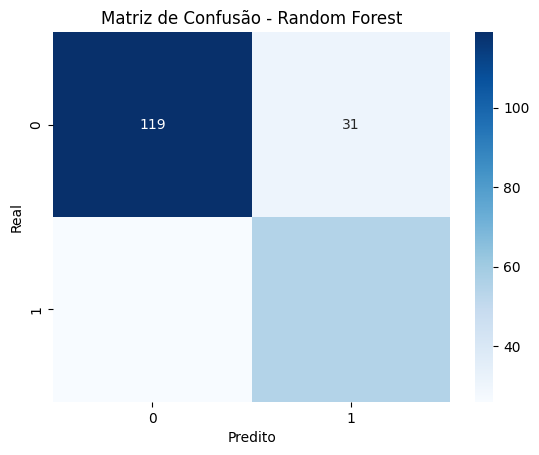

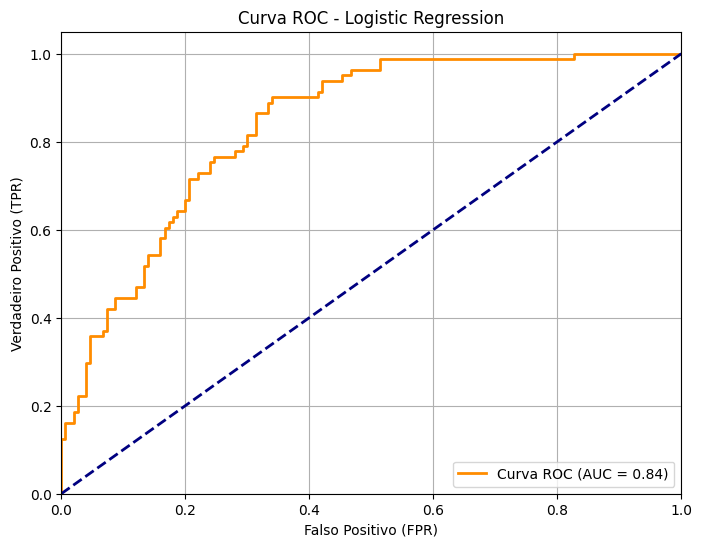

['../src/model.pkl']

In [1]:
import sys
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

sys.path.append(os.path.abspath('../src'))
from data_preprocessing import load_and_clean_data, split_features_labels, normalize_features
from model import get_models, train_model, evaluate_model, save_model

# Etapa 1: Carregar e preparar dados
df = load_and_clean_data('../data/diabetes.csv')
X, y = split_features_labels(df)
X_scaled, scaler = normalize_features(X)

joblib.dump(scaler, '../src/scaler.pkl')

# Etapa 2: Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Antes do SMOTE:", np.bincount(y_train))
print("Depois do SMOTE:", np.bincount(y_train_res))

# Etapa 3: Treinar e avaliar modelos
models = get_models()
best_model = None
best_score = 0
best_name = ''

for name, model in models.items():
    trained = train_model(model, X_train_res, y_train_res)
    acc, report, matrix = evaluate_model(trained, X_test, y_test)

    # Validação cruzada com 5 folds
    cv_scores = cross_val_score(model, X_scaled, y, cv=5)
    print(f"{name} - Cross-Validation (5-fold) Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

    print(f'\n{name} - Acurácia: {acc:.4f}')

    if acc > best_score:
        best_model = trained
        best_score = acc
        best_name = name

print(f'\nMelhor modelo: {best_name} com acurácia de {best_score:.4f}')


# Exemplo com Random Forest
y_pred = best_model.predict(X_test)

print("Relatório de Classificação:\n", classification_report(y_test, y_pred))

# Matriz de confusão
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d')
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# Probabilidades para classe positiva
y_scores = best_model.predict_proba(X_test)[:, 1]

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falso Positivo (FPR)')
plt.ylabel('Verdadeiro Positivo (TPR)')
plt.title(f'Curva ROC - {best_name}')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


joblib.dump(best_model, '../src/model.pkl')